In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My Drive/Colab Notebooks/Image search engine/

/content/drive/My Drive/Colab Notebooks/Image search engine


In [3]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [40]:
''' Project Goal: Given an input image find similar images from the database using cosine similarity score. '''

' Project Goal: Given an input image find similar images from the database using cosine similarity score. '

In [4]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import tensorflow as tf

from tqdm import tqdm
from scipy.spatial.distance import hamming, cosine, euclidean

%matplotlib inline

In [5]:
tf.__version__

'1.15.2'

In [6]:
def image_loader(image_path, image_size):
    '''
    Load an image from drive.
    
    :param image_path: String, path to the image
    :param image_size: tuple, size of an output image Example: image_size=(32, 32)
    '''
    
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, image_size, cv2.INTER_CUBIC)
    return image

In [7]:
img = image_loader('dataset/train/2_truck.png', (32,32))

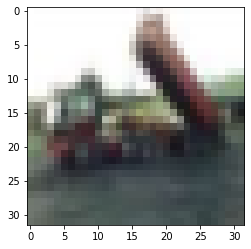

In [8]:
plt.imshow(img)

In [9]:
def cosine_distance(training_set_vectors, query_vector, top_n=50):
    '''
    Calculates cosine distances between query image (vector) and all training set images (vectors).
    
    :param training_set_vectors: numpy Matrix, vectors for all images in the training set
    :param query_vector: numpy vector, query image (new image) vector
    :param top_n: integer, number of closest images to return
    '''
    
    distances = []
    
    for i in range(len(training_set_vectors)): #For Cifar 10 -> 50k images
        distances.append(cosine(training_set_vectors[i], query_vector[0]))
        
    return np.argsort(distances)[:top_n]

In [10]:
def sparse_accuracy(true_labels, predicted_labels):
    '''
    Calculates accuracy of a model based on softmax outputs.
    
    :param true_labels: numpy array, real labels of each sample. Example: [1, 2, 1, 0, 0]
    :param predicted_labels: numpy matrix, softmax probabilities. Example [[0.2, 0.1, 0.7], [0.9, 0.05, 0.05]]
    '''
    
    assert len(true_labels) == len(predicted_labels)
    
    correct = 0
    
    for i in range(len(true_labels)):
        
        if np.argmax(predicted_labels[i]) == true_labels[i]:
            correct += 1
            
    return correct / len(true_labels)

In [11]:
#Define the Model

In [12]:
def model_inputs(image_size):
    '''
    Defines CNN inputs (placeholders).
    
    :param image_size: tuple, (height, width) of an image
    '''
    #-> [Batch_size, image_size[0], image_size[1], 3]
    inputs = tf.placeholder(dtype=tf.float32, shape=[None, image_size[0], image_size[1], 3], name='images')
    targets = tf.placeholder(dtype=tf.int32, shape=[None,], name='targets')
    dropout_prob = tf.placeholder(dtype=tf.float32, name='dropout_probs')
    
    return inputs, targets, dropout_prob

In [13]:
def conv_block(inputs, 
               number_of_filters, 
               kernel_size, 
               strides=(1, 1), 
               padding='SAME', 
               activation=tf.nn.relu, 
               max_pool=True, 
               batch_norm=True):
    
    '''
    Defines convolutional block layer.
    
    :param inputs: data from a previous layer
    :param number_of_filters: integer, number of conv filters
    :param kernel_size: tuple, size of conv layer kernel
    :param padding: string, type of padding technique: SAME or VALID
    :param activation: tf.object, activation function used on the layer
    :param max_pool: boolean, if true the conv block will use max_pool
    :param batch_norm: boolean, if true the conv block will use batch normalization
    '''
    
    conv_features = layer = tf.layers.conv2d(inputs=inputs, 
                                             filters=number_of_filters, 
                                             kernel_size=kernel_size, 
                                             strides=strides, 
                                             padding=padding, 
                                             activation=activation)
    
    if max_pool:
        layer = tf.layers.max_pooling2d(layer, 
                                        pool_size=(2, 2), 
                                        strides=(2, 2),
                                        padding='SAME')
        
    if batch_norm:
        layer = tf.layers.batch_normalization(layer)
        
    return layer, conv_features

In [14]:
def dense_block(inputs, 
                units, 
                activation=tf.nn.relu, 
                dropout_rate=None, 
                batch_norm=True):
    
    '''
    Defines dense block layer.
    
    :param inputs: data from a previous layer
    :param units: integer, number of neurons/units for a dense layer
    :param activation: tf.object, activation function used on the layer
    :param dropout_rate: dropout rate used in this dense block
    :param batch_norm: boolean, if true the conv block will use batch normalization
    '''
    
    dense_features = layer = tf.layers.dense(inputs, 
                                             units=units, 
                                             activation=activation)
    
    if dropout_rate is not None:
        layer = tf.layers.dropout(layer, rate=dropout_rate)
    
    if batch_norm:
        layer = tf.layers.batch_normalization(layer)
        
    return layer, dense_features

In [15]:
def opt_loss(logits, 
             targets, 
             learning_rate):
    
    '''
    Defines model's optimizer and loss functions.
    
    :param logits: pre-activated model outputs
    :param targets: true labels for each input sample
    :param learning_rate: learning_rate
    '''
    
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=targets, logits=logits))
    
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
    
    return loss, optimizer

In [16]:
class ImageSearchModel(object):
    
    def __init__(self, 
                 learning_rate, 
                 image_size, 
                 number_of_classes=10):
        
        '''
        Defines CNN model.
        
        :param learning_rate: learning_rate
        :param image_size: tuple, (height, width) of an image
        :param number_of_classes: integer, number of classes in a dataset.
        '''
        
        tf.reset_default_graph()
        #ops.reset_default_graph()
        
        #model inputs
        self.inputs, self.targets, self.dropout_rate = model_inputs(image_size)
        
        normalized_images = tf.layers.batch_normalization(self.inputs)
        
        #conv_1 block
        conv_block_1, self.conv_1_features = conv_block(inputs=normalized_images, 
                                                        number_of_filters=64, 
                                                        kernel_size=(3, 3), 
                                                        strides=(1, 1), 
                                                        padding='SAME', 
                                                        activation=tf.nn.relu, 
                                                        max_pool=True, 
                                                        batch_norm=True)
        
 
        #conv_2 block
        conv_block_2, self.conv_2_features = conv_block(inputs=conv_block_1, 
                                                        number_of_filters=128, 
                                                        kernel_size=(3, 3), 
                                                        strides=(1, 1), 
                                                        padding='SAME', 
                                                        activation=tf.nn.relu, 
                                                        max_pool=True, 
                                                        batch_norm=True)
        
        #conv_3 block
        conv_block_3, self.conv_3_features = conv_block(inputs=conv_block_2, 
                                                        number_of_filters=256, 
                                                        kernel_size=(5, 5), 
                                                        strides=(1, 1), 
                                                        padding='SAME', 
                                                        activation=tf.nn.relu, 
                                                        max_pool=True, 
                                                        batch_norm=True)
        
        #conv_4 block
        conv_block_4, self.conv_4_features = conv_block(inputs=conv_block_3, 
                                                        number_of_filters=512, 
                                                        kernel_size=(5, 5), 
                                                        strides=(1, 1), 
                                                        padding='SAME', 
                                                        activation=tf.nn.relu, 
                                                        max_pool=True, 
                                                        batch_norm=True)
        
        #flattening
        flat_layer = tf.layers.flatten(conv_block_4)
        
        #1st dense block
        dense_block_1, dense_1_features = dense_block(inputs=flat_layer, 
                                                       units=128, 
                                                       activation=tf.nn.relu, 
                                                       dropout_rate=self.dropout_rate, 
                                                       batch_norm=True)
        
        #2nd dense block
        dense_block_2, self.dense_2_features = dense_block(inputs=dense_block_1, 
                                                       units=256, 
                                                       activation=tf.nn.relu, 
                                                       dropout_rate=self.dropout_rate, 
                                                       batch_norm=True)
        
        #3rd dense block
        dense_block_3, self.dense_3_features = dense_block(inputs=dense_block_2, 
                                                       units=512, 
                                                       activation=tf.nn.relu, 
                                                       dropout_rate=self.dropout_rate, 
                                                       batch_norm=True)
        
        #4th dense block
        dense_block_4, self.dense_4_features = dense_block(inputs=dense_block_3, 
                                                       units=1024, 
                                                       activation=tf.nn.relu, 
                                                       dropout_rate=self.dropout_rate, 
                                                       batch_norm=True)
        
        #output layer
        logits = tf.layers.dense(inputs=dense_block_4, 
                                 units=number_of_classes, 
                                 activation=None)
        
        self.predictions = tf.nn.softmax(logits)
        
        self.loss, self.optimizer = opt_loss(logits=logits, 
                                             targets=self.targets, 
                                             learning_rate=learning_rate)

In [17]:
learning_rate = 0.001
dropout_probs = 0.6
image_size = (32, 32)

In [39]:
def create_training_set_vectors(model, 
                                X_train, 
                                y_train,
                                batch_size,
                                checkpoint_path, 
                                image_size, 
                                distance='cosine'):
    
    '''
    Creates training set vectors and saves them in a pickle file.
    
    :param model: CNN model
    :param X_train: numpy array, loaded training set images
    :param y_train: numpy array,loaded training set labels
    :param batch_size: integer, number of samples to put trhough the model at once
    :param checkpoint_path: string, path to the model checkpoint
    :param image_size: tuple, single image (height, width)
    :param distance: string, type of distance to be used, 
                             this parameter is used to choose a way how to prepare and save training set vectors
    '''
            
    #Define session
    session = tf.Session()
    session.run(tf.global_variables_initializer())
    
    #restore session
    saver = tf.train.Saver()
    saver.restore(session, checkpoint_path)
    
    dense_2_features = []
    dense_4_features = []

    #iterate through training set
    for ii in tqdm(range(len(X_train) // batch_size)):
        start_id = ii*batch_size
        end_id = start_id + batch_size

        X_batch = X_train[start_id:end_id]

        feed_dict = {model.inputs:X_batch, 
                     model.dropout_rate:0.0}
        
        dense_2, dense_4 = session.run([model.dense_2_features, model.dense_4_features], feed_dict=feed_dict)
        
        dense_2_features.append(dense_2)
        dense_4_features.append(dense_4)
        
    dense_2_features = np.vstack(dense_2_features)
    dense_4_features = np.vstack(dense_4_features)
    #hamming distance - vectors processing
    if distance == 'cosine':
        training_vectors = np.hstack((dense_2_features, dense_4_features))
        training_vectors = np.hstack((training_vectors, color_features[:len(training_vectors)]))
        with open('cosine_train_vectors_new.pickle', 'wb') as f:
            pickle.dump(training_vectors, f)

In [19]:
model = ImageSearchModel(learning_rate=learning_rate, image_size=image_size)

Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Use keras.layers.dropout instead.


In [ ]:
create_training_set_vectors(model, X_train, y_train, batch_size, 'saver/model_epoch_5.ckpt', image_size)

In [21]:
def simple_inference(model, 
                     session,
                     train_set_vectors, 
                     uploaded_image_path,
                     image_size, 
                     distance='cosine'):
    
    '''
    Doing simple inference for single uploaded image.
    
    :param model: CNN model
    :param session: tf.Session, restored session
    :param train_set_vectors: loaded training set vectors
    :param uploaded_image_path: string, path to the uploaded image
    :param image_size: tuple, single image (height, width)
    :param dsitance: string, type of distance to be used, 
                             this parameter is used to choose a way how to prepare vectors
    '''
    
    image = image_loader(uploaded_image_path, image_size)
    channels = cv2.split(image)
    features = []
    
    for chan in channels:
        hist = cv2.calcHist([chan], [0], None, [256], [0, 256])
        features.append(hist)

    color_features = np.vstack(features).T
    
    feed_dict = {model.inputs:[image], model.dropout_rate:0.0}
    
    dense_2_features, dense_4_features = session.run([model.dense_2_features, model.dense_4_features], feed_dict=feed_dict)
    
    closest_ids = None

    if distance == 'cosine':
        uploaded_image_vector = np.hstack((dense_2_features, dense_4_features))
        
        closest_ids = cosine_distance(train_set_vectors, uploaded_image_vector)
        
    return closest_ids

In [22]:
model = ImageSearchModel(learning_rate=learning_rate, image_size=image_size)

session = tf.Session()
session.run(tf.global_variables_initializer())

In [23]:
saver = tf.train.Saver()
saver.restore(session, "saver/model_epoch_5.ckpt")

INFO:tensorflow:Restoring parameters from saver/model_epoch_5.ckpt


In [25]:
with open('dataset/train_images_pickle.pickle', 'rb') as f:
    train_image_paths = pickle.load(f)

In [26]:
train_image_paths[:10]

['cifar/train/0_frog.png',
 'cifar/train/10000_automobile.png',
 'cifar/train/10001_frog.png',
 'cifar/train/10002_frog.png',
 'cifar/train/10003_ship.png',
 'cifar/train/10004_ship.png',
 'cifar/train/10005_cat.png',
 'cifar/train/10006_deer.png',
 'cifar/train/10007_frog.png',
 'cifar/train/10008_airplane.png']

In [27]:
with open('cosine_train_vectors.pickle', 'rb') as f:
    train_set_vectors = pickle.load(f)

In [34]:
test_image = 'dataset/test/1_ship.png'

In [37]:
result_ids = simple_inference(model, session, train_set_vectors, test_image, image_size, distance='cosine')

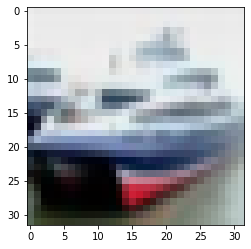

In [35]:
img = image_loader(test_image, (32,32))
plt.imshow(img)

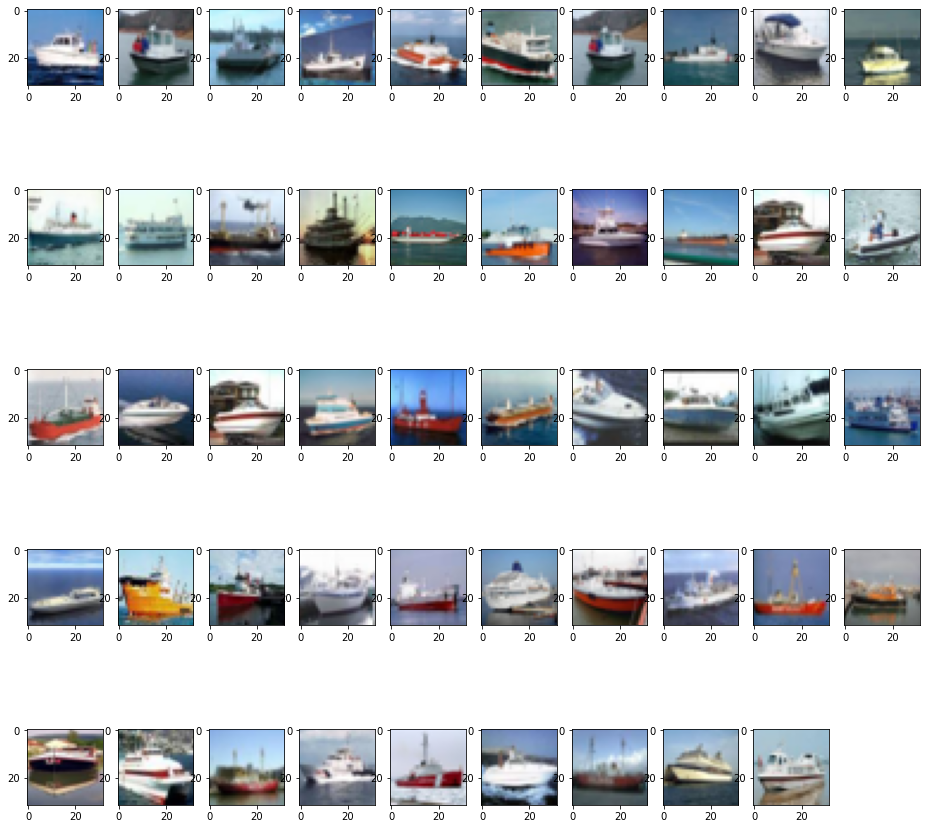

In [ ]:
w = 10
h = 10
fig = plt.figure(figsize=(16, 16))
colums = 10
rows = 5
for i in range(1, colums*rows+1):
    try:
        image = image_loader(train_image_paths[result_ids[i]], image_size)
        fig.add_subplot(rows, colums, i)
        plt.imshow(image)
    except:
        pass
plt.show()